# 1. Data Exploration & Cleaning

## Import dependencies, set up environment
1. `python3 -m venv .venv`
2. utilize virtual environment
    - (LINUX/MAC) `source .venv/bin/activate`
    - (WINDOWS) `.venv\Scripts\Activate.ps1`
3. `pip install -r requirements.txt`

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy as ap
import scipy as sp
import io

Upon reviewing the quality of data from the "Planetary Systems" (PS) database, it was deemed better to pivot towards the "Planetary Systems Composite Data" (PSCompPars) database. In brief:
1. PS details a record for each exoplanet and each one of its references (this helps us reach original literature analyses of these bodies). Missing data is prevelant.
2. PSCompPars curates a “best available” or “most complete” set of parameters for each planet, pulling from multiple references.

So far as our exploration of exoplanets and their stars (studying the whole population of exoplanets thus far), this seems outside the scope of our analysis, and creates a cumbersome process of exploring the data. This will aid in limiting time spent cleaning the dataset, and limit our analysis to 6065 from a daunting ~32,000 records.

For an explanation on how the composite dataset aggregates all available information on exoplanet figures, please see <https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html>.

In [18]:
# TAP base URL (Planetary Systems)
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
# The "Planetary Systems" database (confirmed exoplanets) is encoded as "ps" within the Exoplanet Archive
ADQL_query =    "SELECT " \
                "pl_controv_flag, pl_name, hostname, pl_letter, sy_snum, discoverymethod, disc_year," \
                "pl_radj, pl_massj, st_spectype, st_rad, st_mass, st_met, st_lum " \
                "FROM PSCompPars"

# Request data as CSV
params = {
    "query": ADQL_query,
    "format": "csv"
}
response = requests.get(url, params=params)

# Load into "Planetary Systems" DataFrame
pscp = pd.read_csv(io.StringIO(response.text))
print("Data loaded successfully. Number of records:", len(pscp))

Data loaded successfully. Number of records: 6065


Over 355 columns in this dataset!! All different features we can analyze in another related project pertaining to exoplanet exploration and methods for doing so . . .

After reviewing the column descriptions (as defined here: <https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html>), the following features are relevant to our exploration:
1. pl_controv_flag (is the comfirmation of this planet questioned?)
2. pl_name
3. hostname (most common star name)
4. pl_letter
5. sy_snum
6. discoverymethod
7. disc_year
8. pl_radj
9. pl_massj
10. st_spectype
11. st_rad
12. st_mass
13. st_met
14. st_lum

---

## Begin Exploration of Data

### Basic Exploration

In [20]:
print('======================================')
print('INFO')
print('======================================')
print(pscp.info())

print('======================================')
print('HEAD')
print('======================================')
print(pscp.head())

print('======================================')
print('DESCRIPTION')
print('======================================')
print(pscp.describe())

print('======================================')
print('MISSING VALUES')
print('======================================')
print(pscp.isnull().sum())

print('======================================')
print('VALUE COUNTS')
print('======================================')
for col in pscp:
    print(pscp[col].value_counts())

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6065 entries, 0 to 6064
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_controv_flag  6065 non-null   int64  
 1   pl_name          6065 non-null   object 
 2   hostname         6065 non-null   object 
 3   pl_letter        6065 non-null   object 
 4   sy_snum          6065 non-null   int64  
 5   discoverymethod  6065 non-null   object 
 6   disc_year        6065 non-null   int64  
 7   pl_radj          6015 non-null   float64
 8   pl_massj         2290 non-null   float64
 9   st_spectype      2250 non-null   object 
 10  st_rad           5767 non-null   float64
 11  st_mass          6058 non-null   float64
 12  st_met           5532 non-null   float64
 13  st_lum           5773 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 663.5+ KB
None
HEAD
   pl_controv_flag        pl_name     hostname pl_letter  sy_snum  \
0        

### Exoplanets and Their Stars

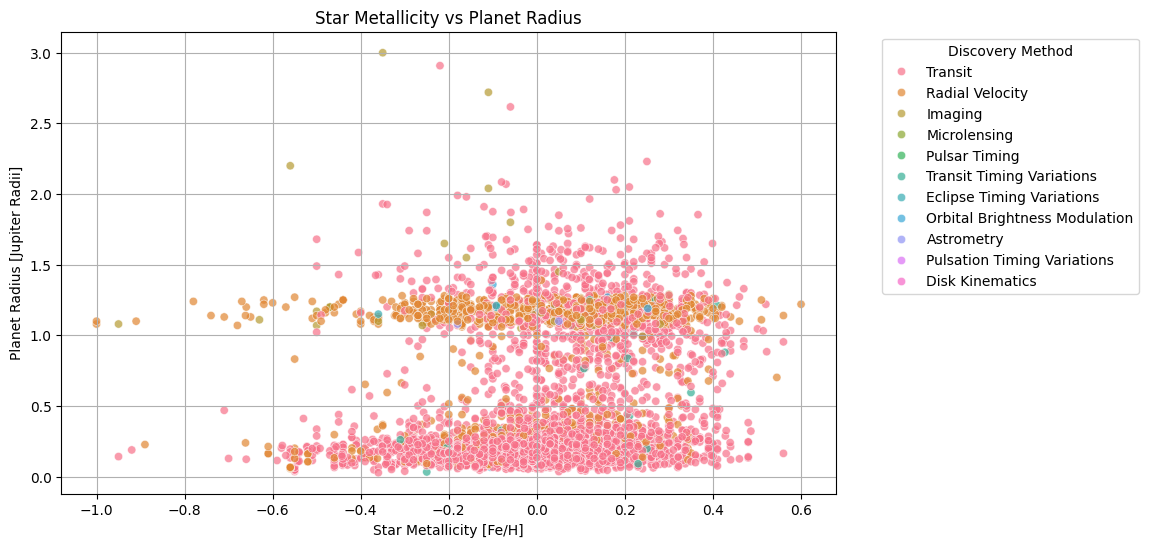

In [22]:
# example analysis of star metallicity vs planet radius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pscp, x='st_met', y='pl_radj', hue='discoverymethod', alpha=0.7)
plt.title('Star Metallicity vs Planet Radius')
plt.xlabel('Star Metallicity [Fe/H]')
plt.ylabel('Planet Radius [Jupiter Radii]')
plt.legend(title='Discovery Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

In [ ]:
# Exoplanets vs star types


In [ ]:
# Scatterplot of star size vs 

In [ ]:
# Exoplanets vs star metallicity